# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

### (1) 라이브러리 불러오기

* **세부 요구사항**
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.



### (2) 데이터 로딩
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [2]:
path = ''

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/KT aivleschool/KT_aivle_school_AI_track/16. MINI_PJ6/장애인콜택시 대기시간 예측/'

#### 3) 데이터 읽어오기

In [12]:
taxi = pd.read_csv(path + 'open_data.csv')
weather = pd.read_csv(path + 'weather.csv')

In [13]:
taxi.tail()

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
2917,2022-12-27,669,5635,4654,44.4,2198,8178
2918,2022-12-28,607,5654,4648,44.8,2161,7882
2919,2022-12-29,581,5250,4247,52.5,2229,8433
2920,2022-12-30,600,5293,4200,38.3,2183,8155
2921,2022-12-31,263,2167,1806,33.7,2318,9435


In [14]:
weather.tail()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
4013,2022-12-27,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-28,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-29,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-30,2.1,-4.0,0.0,87.0,38.0,10.84
4017,2022-12-31,-4.4,-4.4,0.0,66.0,66.0,0.00


#### 4) 기본정보 확인하기
* .info() 등을 이용하여 기본 정보를 확인합니다.

In [15]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [16]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


#### 5) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.


In [17]:
taxi = taxi.rename(columns={'기준일': 'Date', '차량운행': 'Vehicle Operation', '접수건': 'Service Requests', '탑승건': 'Boardings', '평균대기시간': 'Average Wait Time', '평균요금': 'Average Fare', '평균승차거리': 'Average Distance Traveled'})


## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [96]:
taxi_copy = taxi.copy()

In [97]:
# 'Date'열을 datetime 자료형으로 변환
taxi_copy['Date'] = pd.to_datetime(taxi_copy['Date'])

In [20]:
taxi_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2922 non-null   datetime64[ns]
 1   Vehicle Operation          2922 non-null   int64         
 2   Service Requests           2922 non-null   int64         
 3   Boardings                  2922 non-null   int64         
 4   Average Wait Time          2922 non-null   float64       
 5   Average Fare               2922 non-null   int64         
 6   Average Distance Traveled  2922 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 159.9 KB


In [98]:
# 'Date'에서 '요일', '주차', '월', '연도' 정보 추출하여 새로운 열 추가
taxi_copy['Day of Week'] = taxi_copy['Date'].dt.day_name()
taxi_copy['Week'] = taxi_copy['Date'].dt.week
taxi_copy['Month'] = taxi_copy['Date'].dt.month
taxi_copy['Year'] = taxi_copy['Date'].dt.year

<ipython-input-98-8121619e1622>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  taxi_copy['Week'] = taxi_copy['Date'].dt.week


In [22]:
taxi_copy.tail()

,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,Year
2917,2022-12-27,669,5635,4654,44.4,2198,8178,Tuesday,52,12,2022
2918,2022-12-28,607,5654,4648,44.8,2161,7882,Wednesday,52,12,2022
2919,2022-12-29,581,5250,4247,52.5,2229,8433,Thursday,52,12,2022
2920,2022-12-30,600,5293,4200,38.3,2183,8155,Friday,52,12,2022
2921,2022-12-31,263,2167,1806,33.7,2318,9435,Saturday,52,12,2022


In [23]:
taxi_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2922 non-null   datetime64[ns]
 1   Vehicle Operation          2922 non-null   int64         
 2   Service Requests           2922 non-null   int64         
 3   Boardings                  2922 non-null   int64         
 4   Average Wait Time          2922 non-null   float64       
 5   Average Fare               2922 non-null   int64         
 6   Average Distance Traveled  2922 non-null   int64         
 7   Day of Week                2922 non-null   object        
 8   Week                       2922 non-null   int64         
 9   Month                      2922 non-null   int64         
 10  Year                       2922 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(1)
memory usage: 2

### (2) 일별

In [32]:
pip install koreanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.5 MB/s eta 0:00:00


In [38]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

def plot_bivariate_analysis(df, groupby_col, analysis_col):
    """
    이변량 관계를 시각화하는 함수
    
    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임
    groupby_col : str
        그룹화할 기준 열의 컬럼명
    analysis_col : str
        분석할 열의 컬럼명
    """
    # 그룹화하여 분석할 데이터프레임 생성
    grouped_df = df.groupby([groupby_col])[analysis_col].sum().reset_index()
    
    # 시각화
    plt.figure(figsize=(15,10))
    sns.lineplot(data=grouped_df, x=groupby_col, y=analysis_col)
    plt.xlabel(groupby_col)
    plt.ylabel(analysis_col)
    plt.title(f"{groupby_col}별 {analysis_col} 변화")
    plt.show()


* 차량 운행수

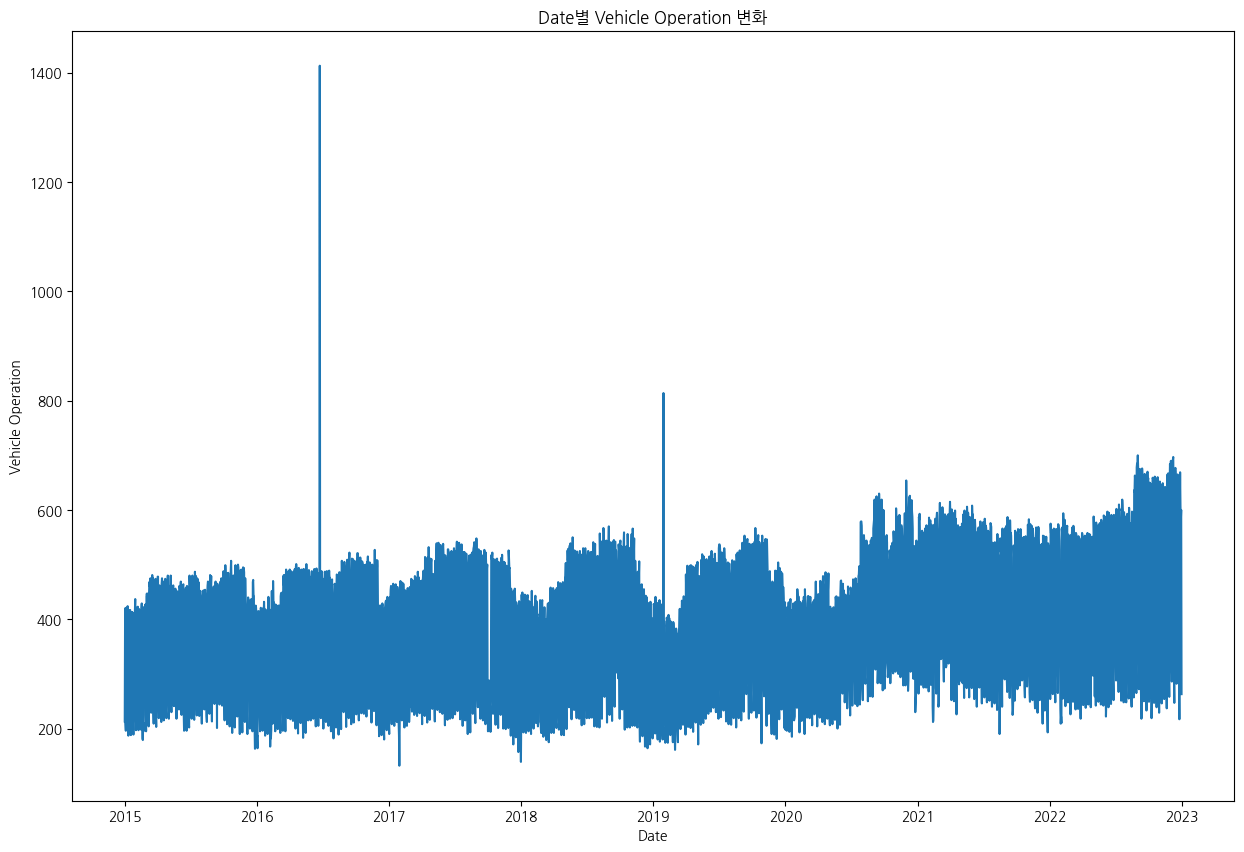

In [39]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Vehicle Operation')

taxi = taxi.rename(columns={'기준일': 'Date', '차량운행': 'Vehicle Operation', '접수건': 'Service Requests', '탑승건': 'Boardings', '평균대기시간': 'Average Wait Time', '평균요금': 'Average Fare', '평균승차거리': 'Average Distance Traveled'})


* 접수건, 탑승건

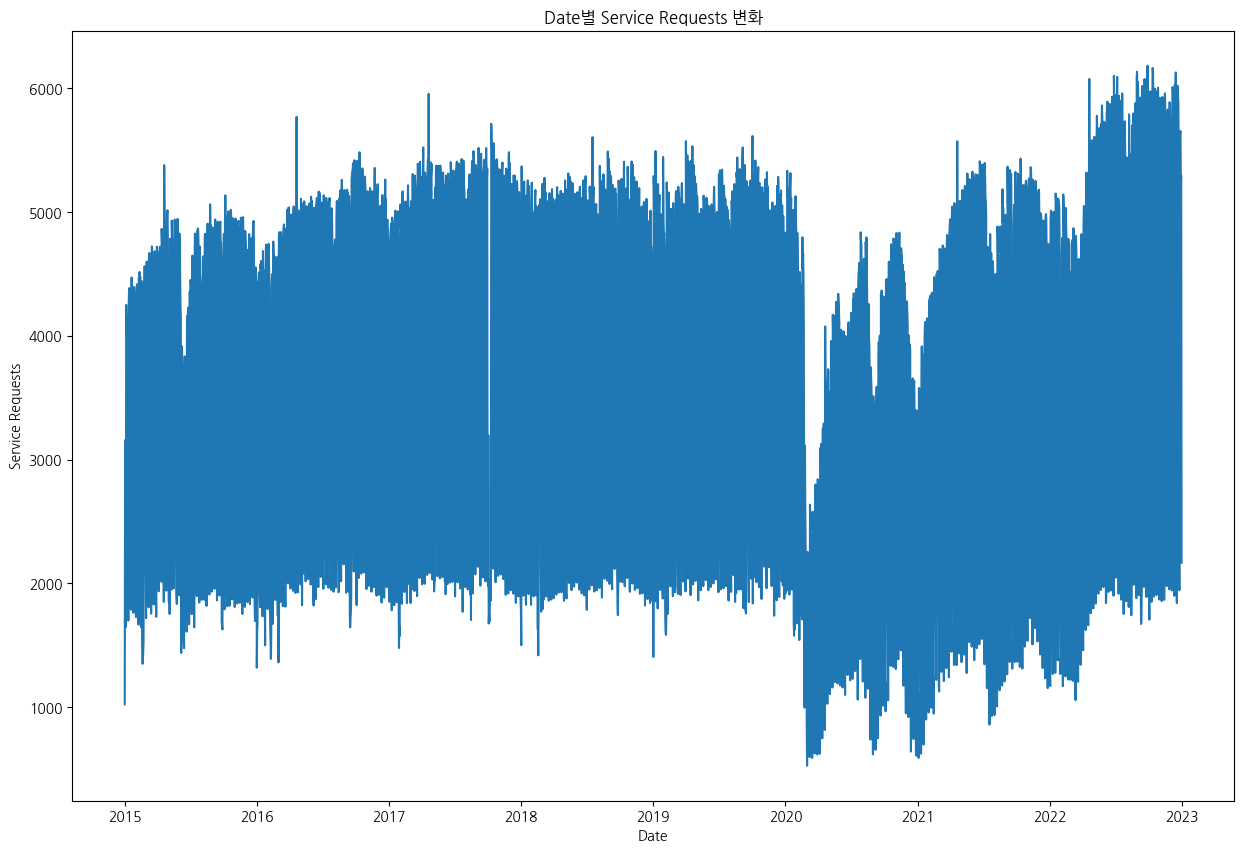

In [40]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Service Requests')

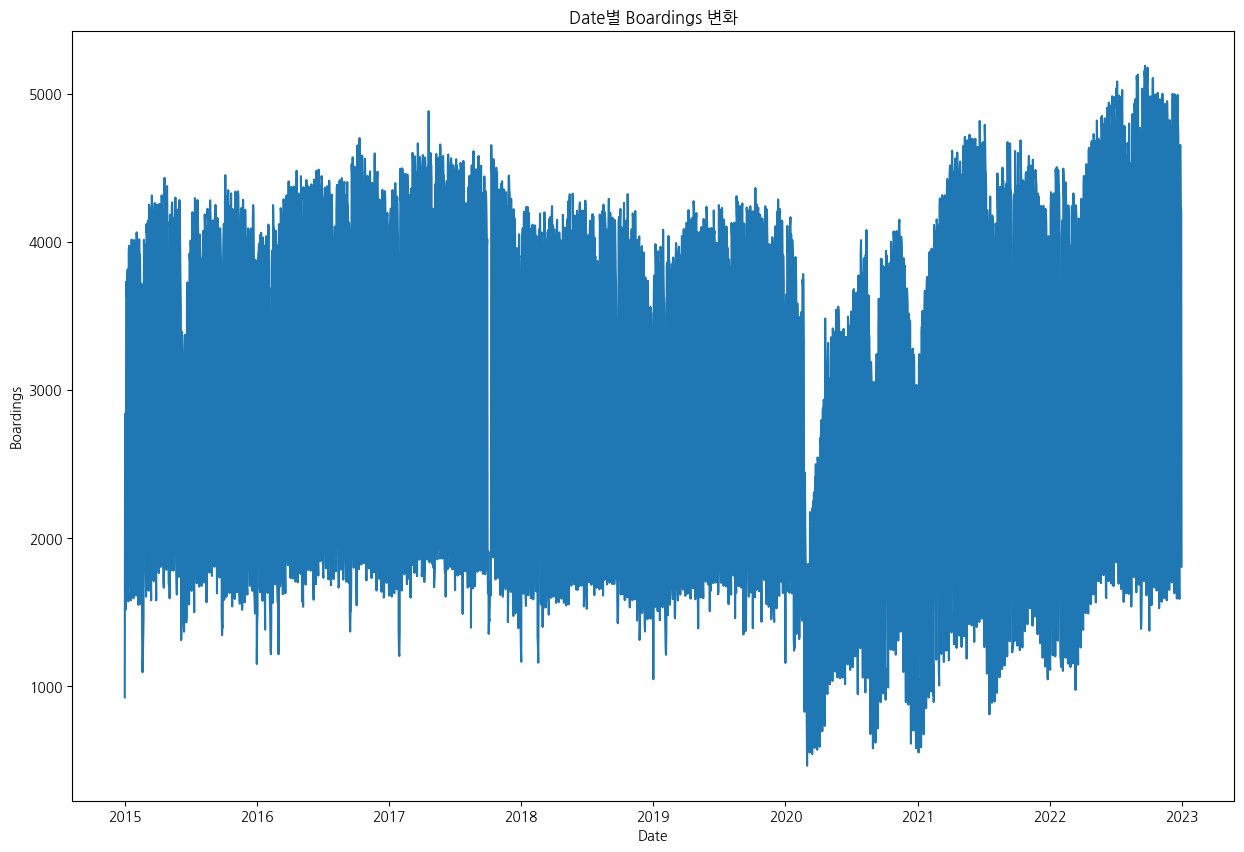

In [41]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Boardings')

* 대기시간

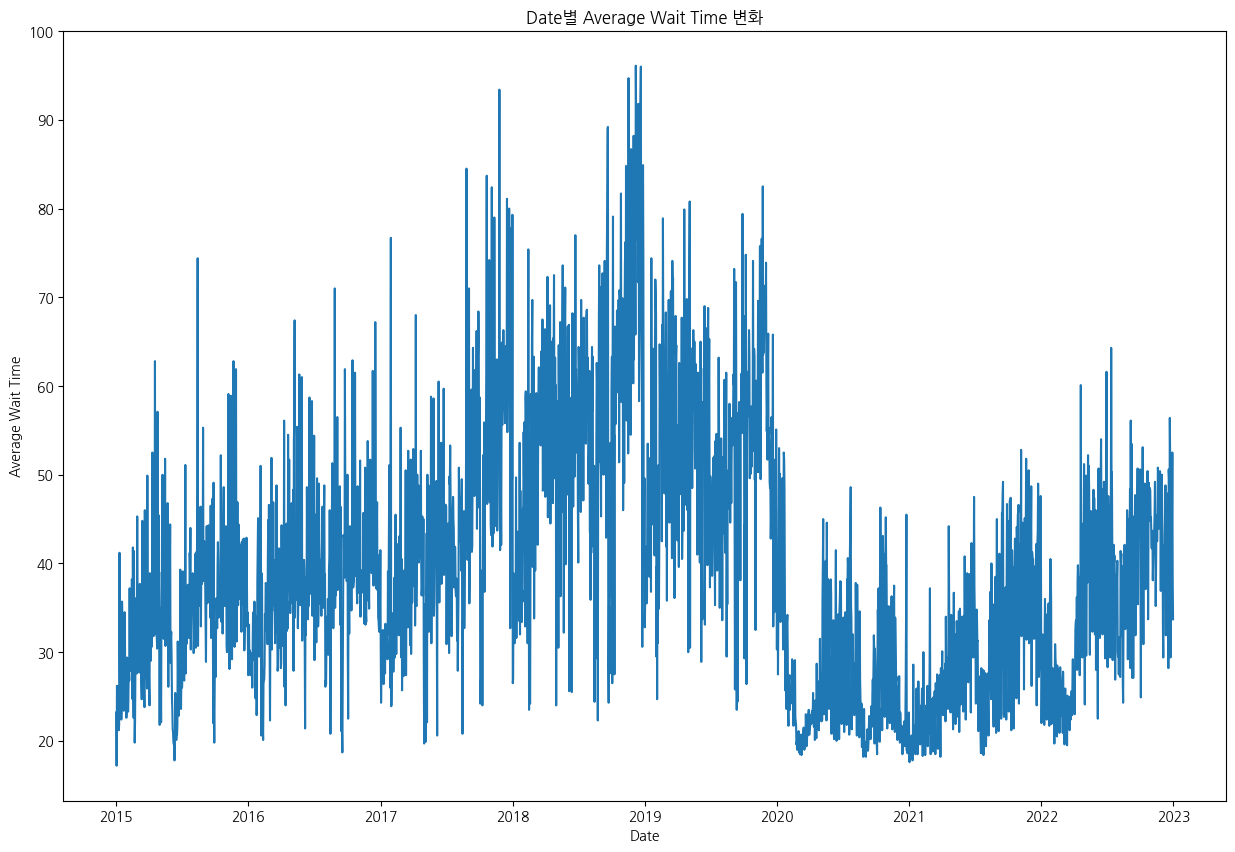

In [43]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Average Wait Time')


* 운임

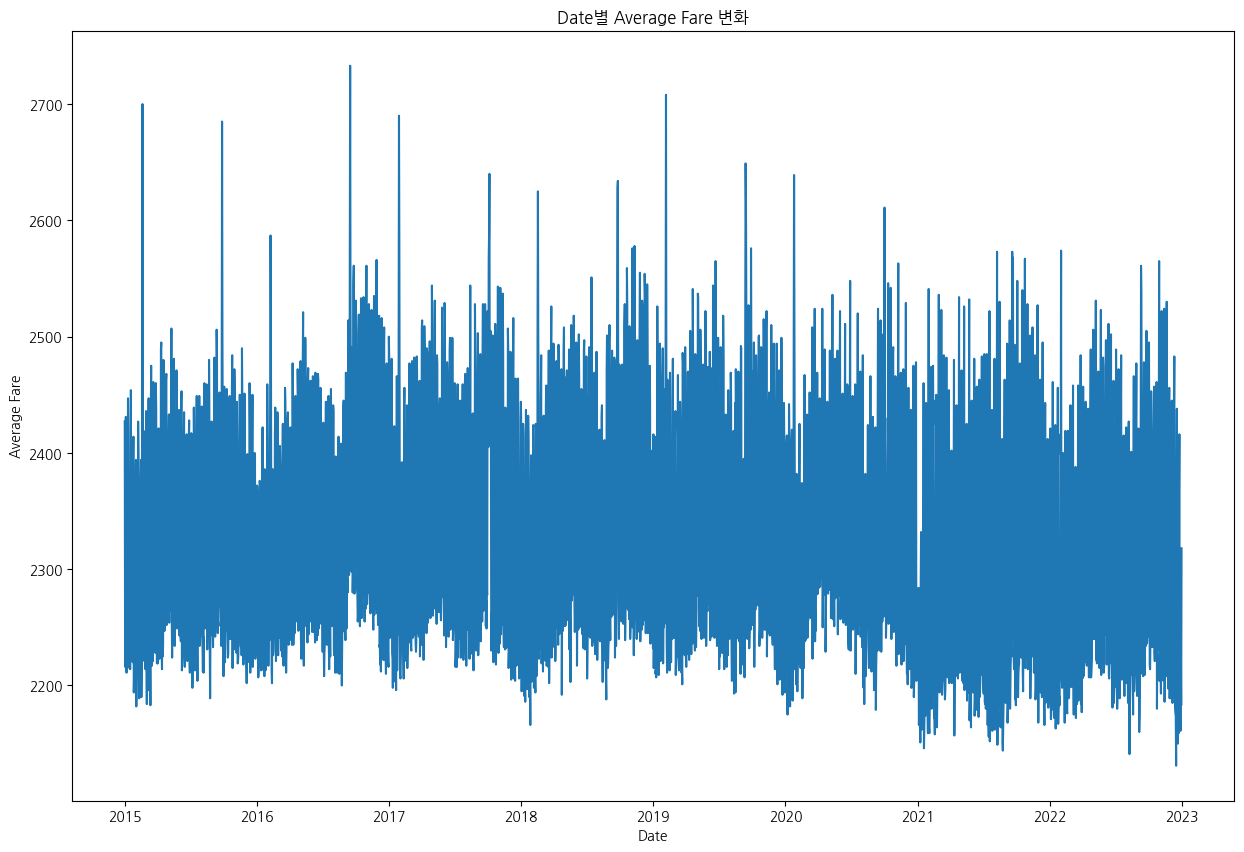

In [44]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Average Fare')


* 이동거리

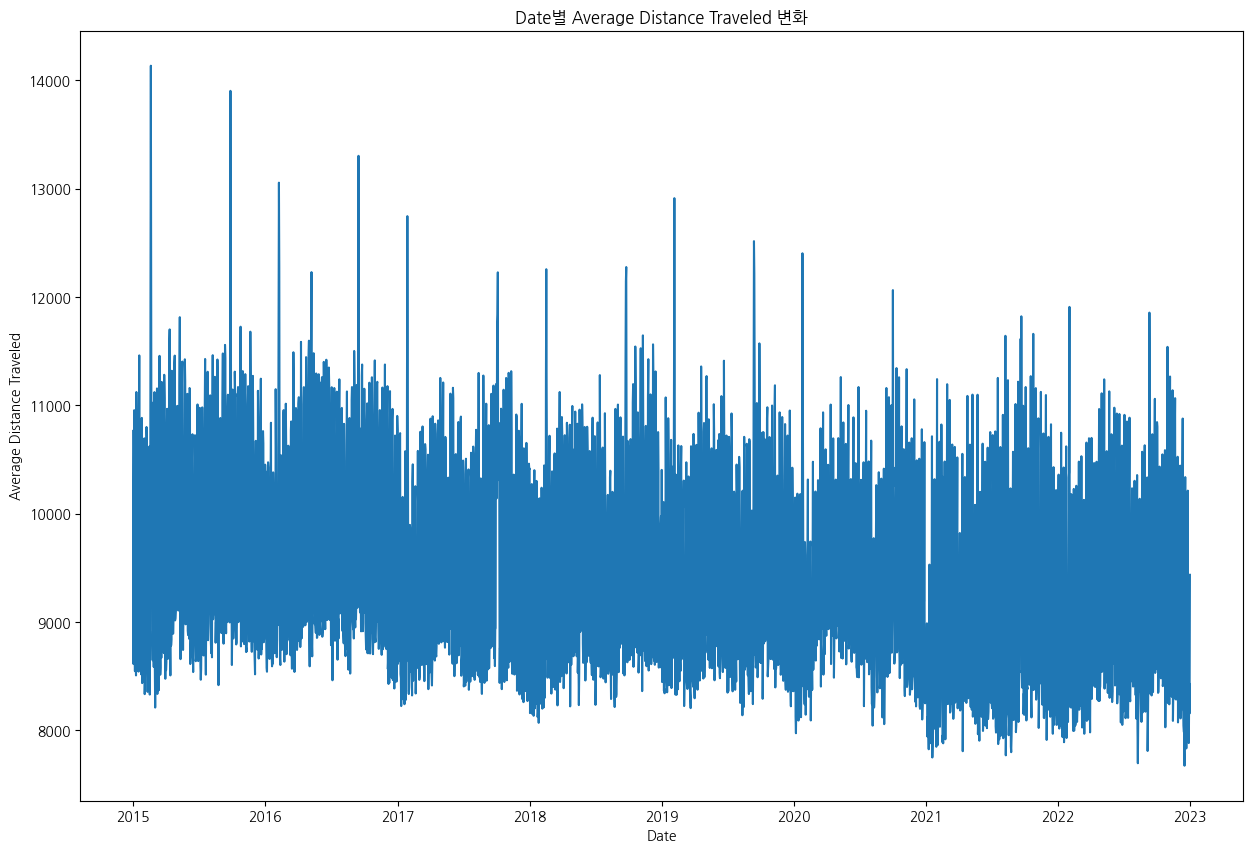

In [45]:
plot_bivariate_analysis(taxi_copy, 'Date', 'Average Distance Traveled')


In [46]:
taxi_copy.tail()

,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,Year
2917,2022-12-27,669,5635,4654,44.4,2198,8178,Tuesday,52,12,2022
2918,2022-12-28,607,5654,4648,44.8,2161,7882,Wednesday,52,12,2022
2919,2022-12-29,581,5250,4247,52.5,2229,8433,Thursday,52,12,2022
2920,2022-12-30,600,5293,4200,38.3,2183,8155,Friday,52,12,2022
2921,2022-12-31,263,2167,1806,33.7,2318,9435,Saturday,52,12,2022


### (3) 요일별

In [77]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

def plot_barplot_analysis(df, groupby_col, analysis_col):
    """
    이변량 관계를 시각화하는 함수
    
    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임
    groupby_col : str
        그룹화할 기준 열의 컬럼명
    analysis_col : str
        분석할 열의 컬럼명
    """
    # 그룹화하여 분석할 데이터프레임 생성
    grouped_df = df.groupby([groupby_col])[analysis_col].sum().reset_index()
    
    # 시각화
    plt.figure(figsize=(15,10))
    sns.barplot(data=grouped_df, x=groupby_col, y=analysis_col)
    plt.xticks(rotation=0)
    plt.xlabel(groupby_col)
    plt.ylabel(analysis_col)
    plt.title(f"{groupby_col}별 {analysis_col} 변화")
    plt.show()


* 차량 운행수

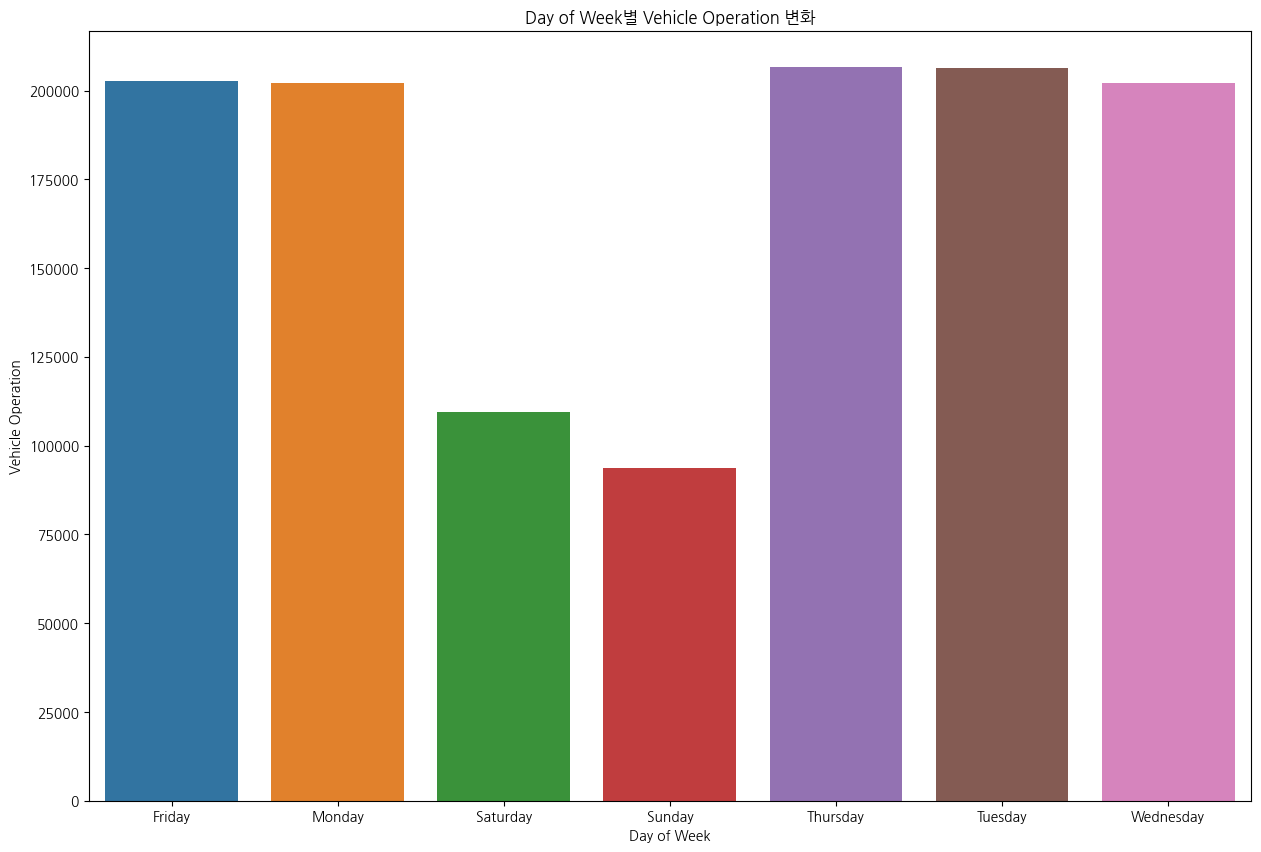

In [78]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Vehicle Operation')


* 접수건, 탑승건

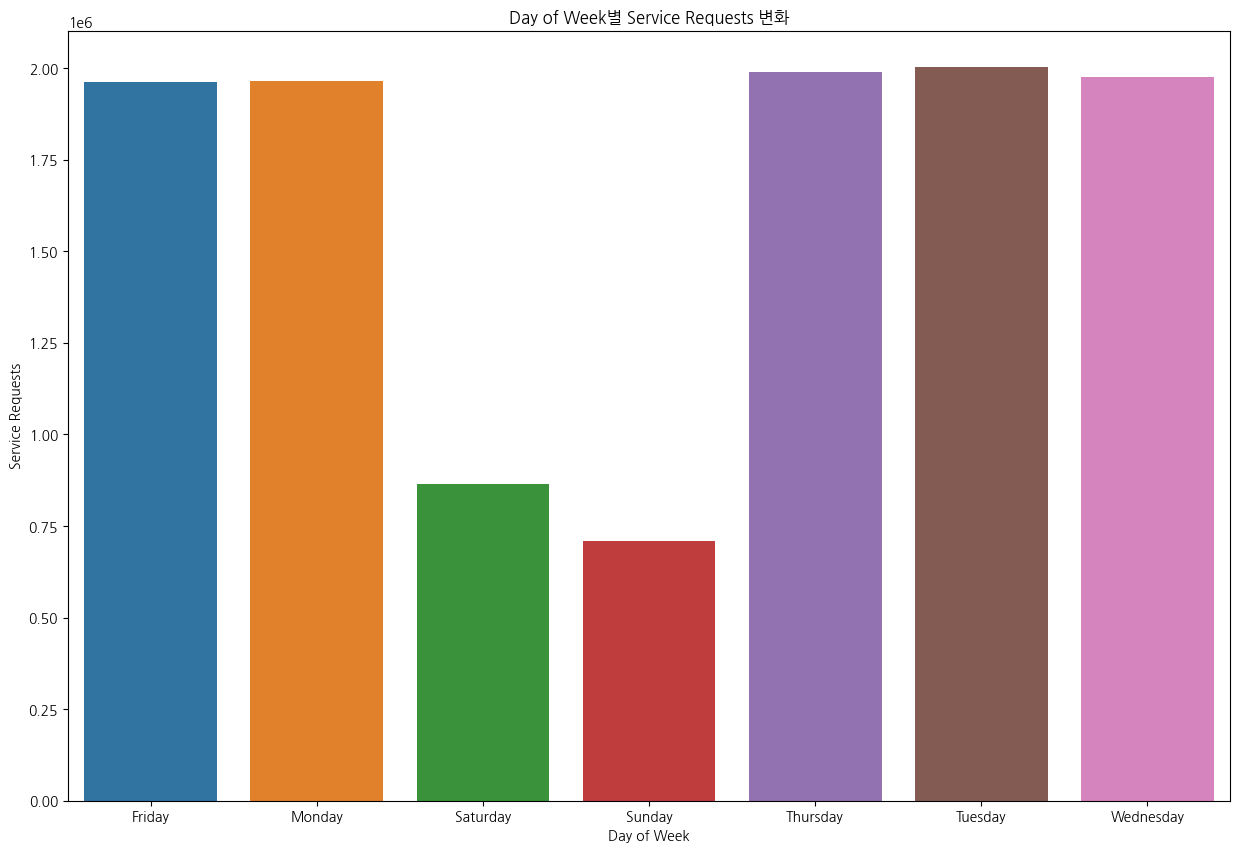

In [79]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Service Requests')


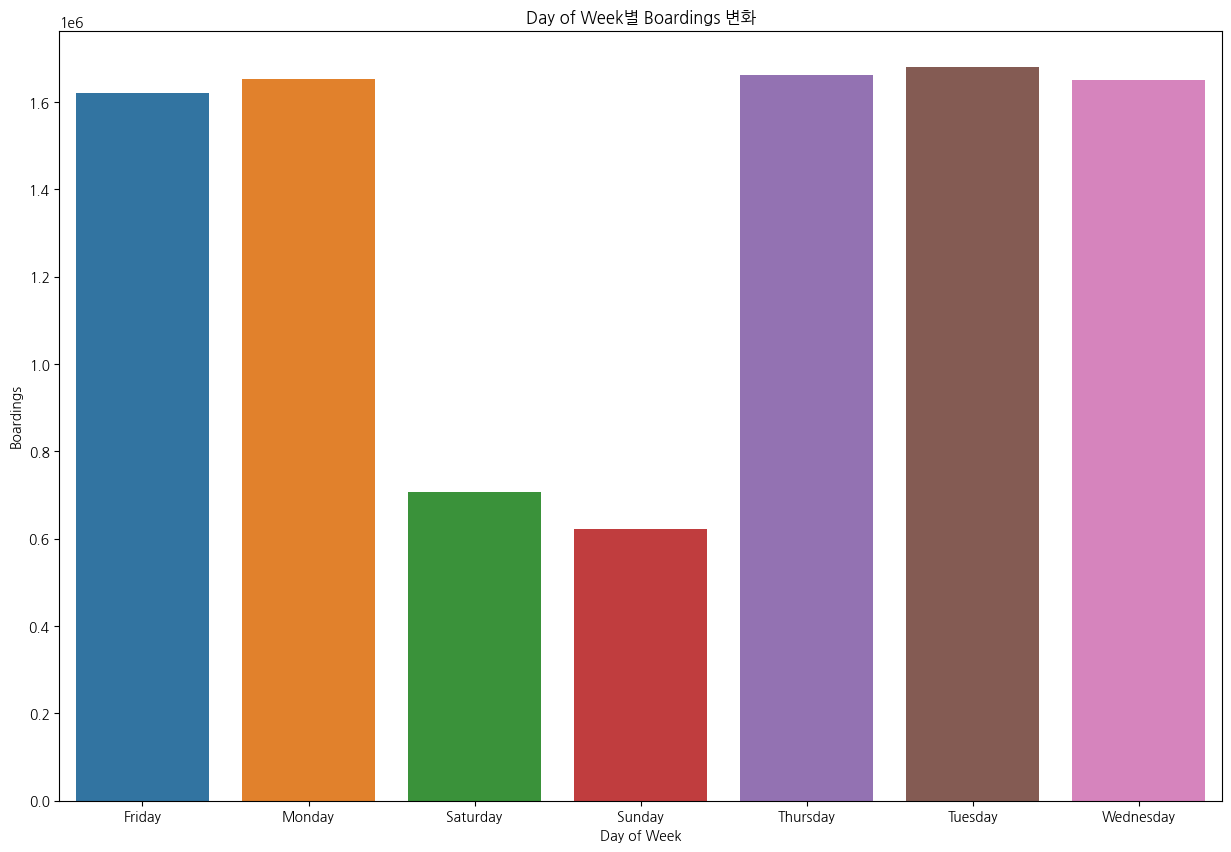

In [80]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Boardings')


* 대기시간

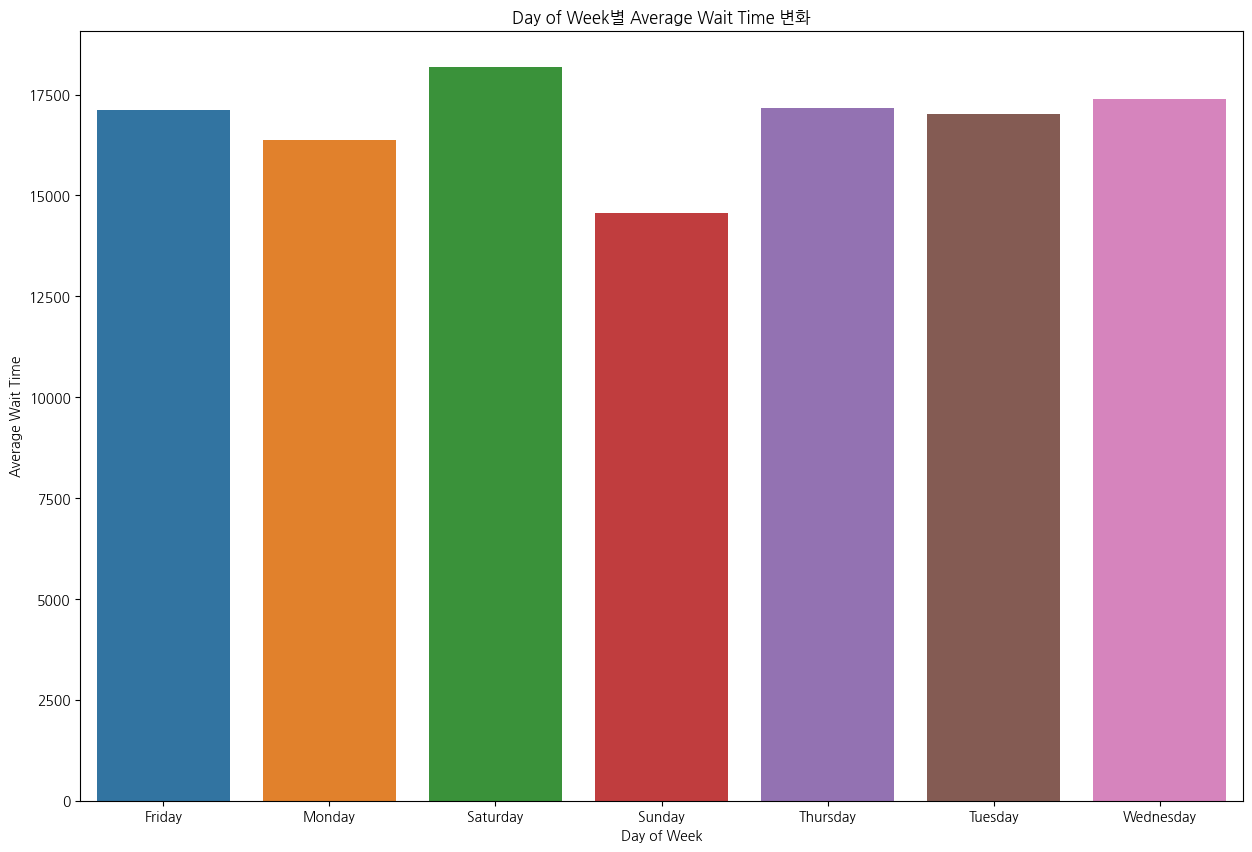

In [81]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Average Wait Time')


* 운임

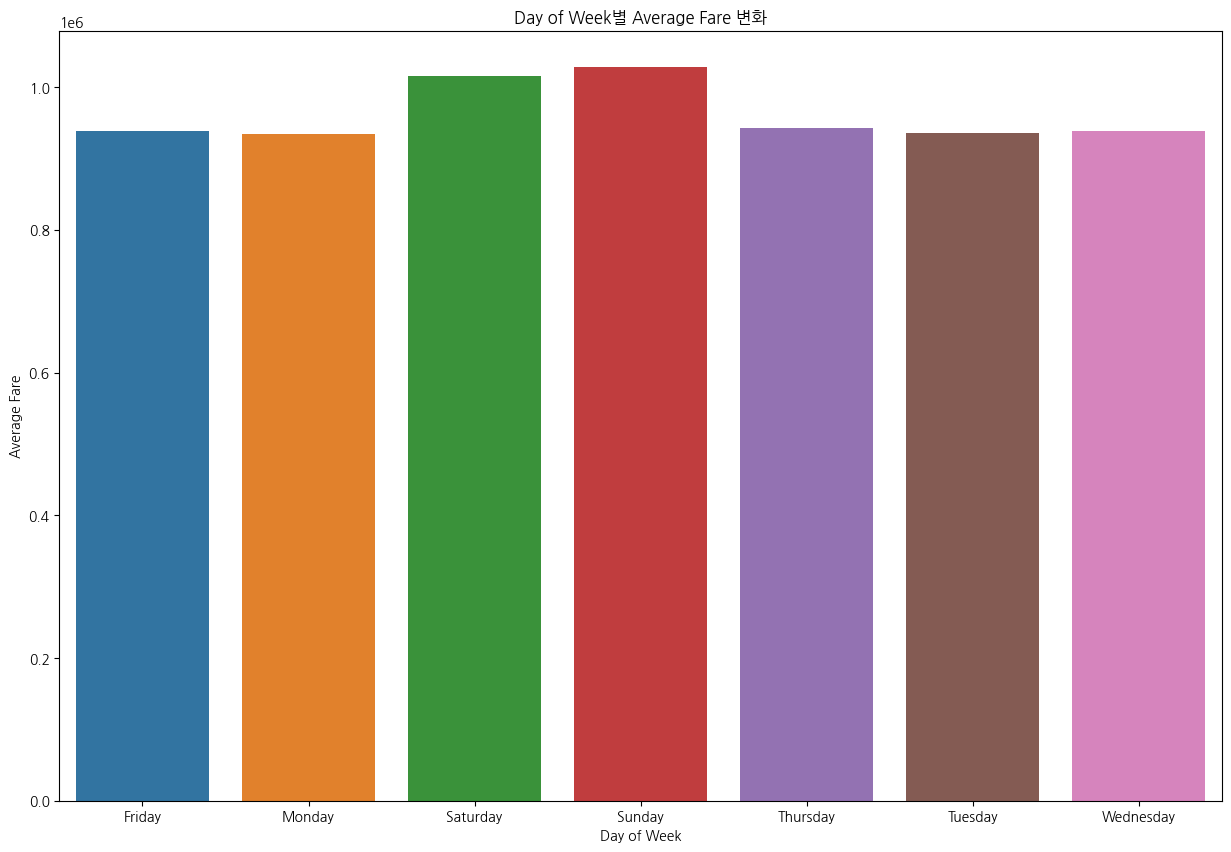

In [82]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Average Fare')


* 이동거리

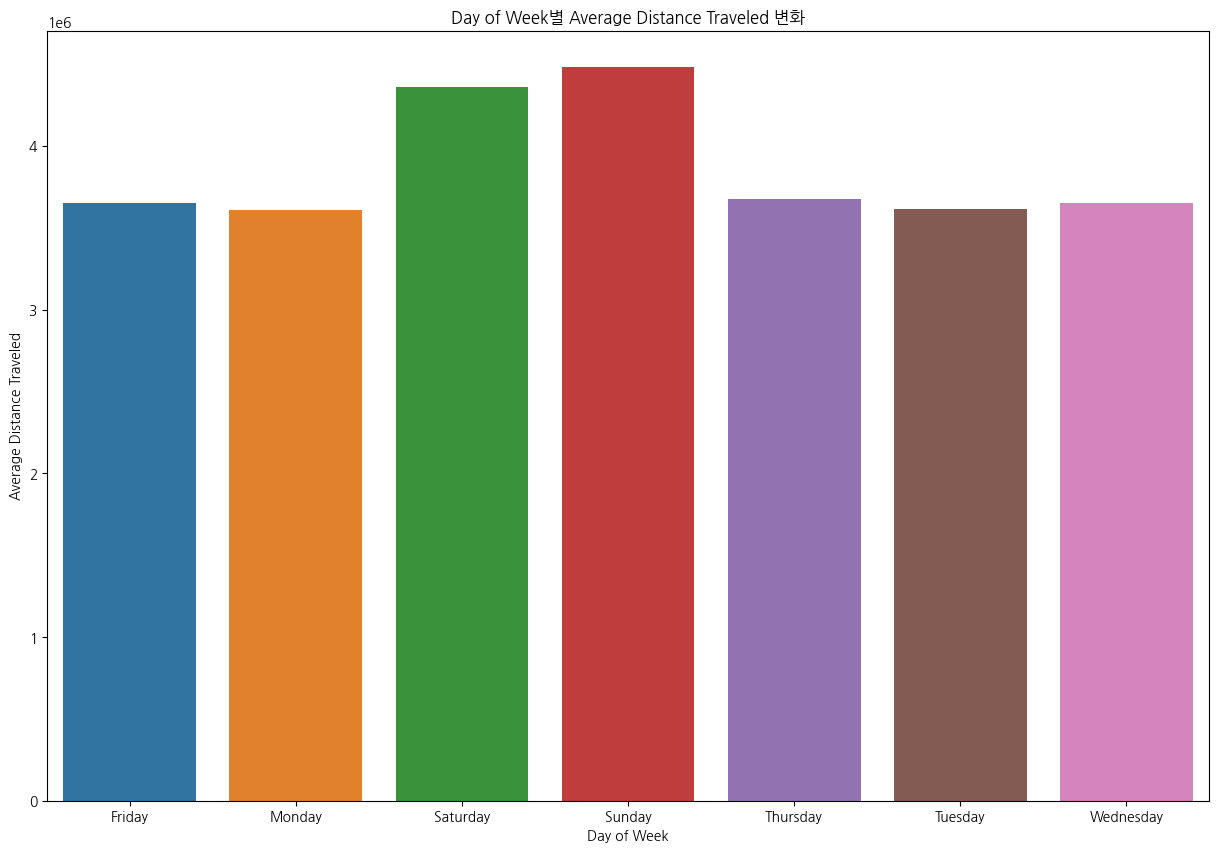

In [83]:
plot_barplot_analysis(taxi_copy, 'Day of Week', 'Average Distance Traveled')


### (4) 월별

* 차량 운행수

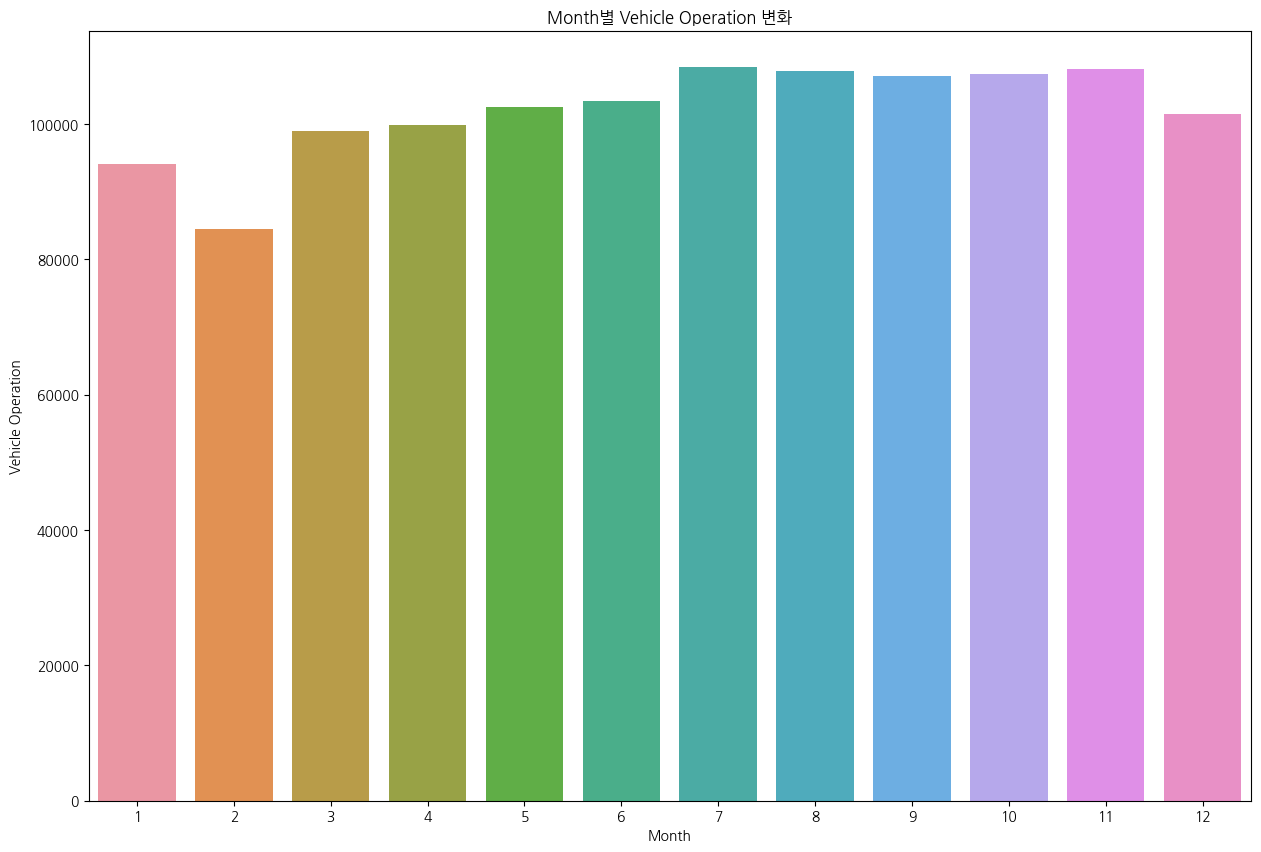

In [85]:
plot_barplot_analysis(taxi_copy, 'Month', 'Vehicle Operation')


* 접수건, 탑승건

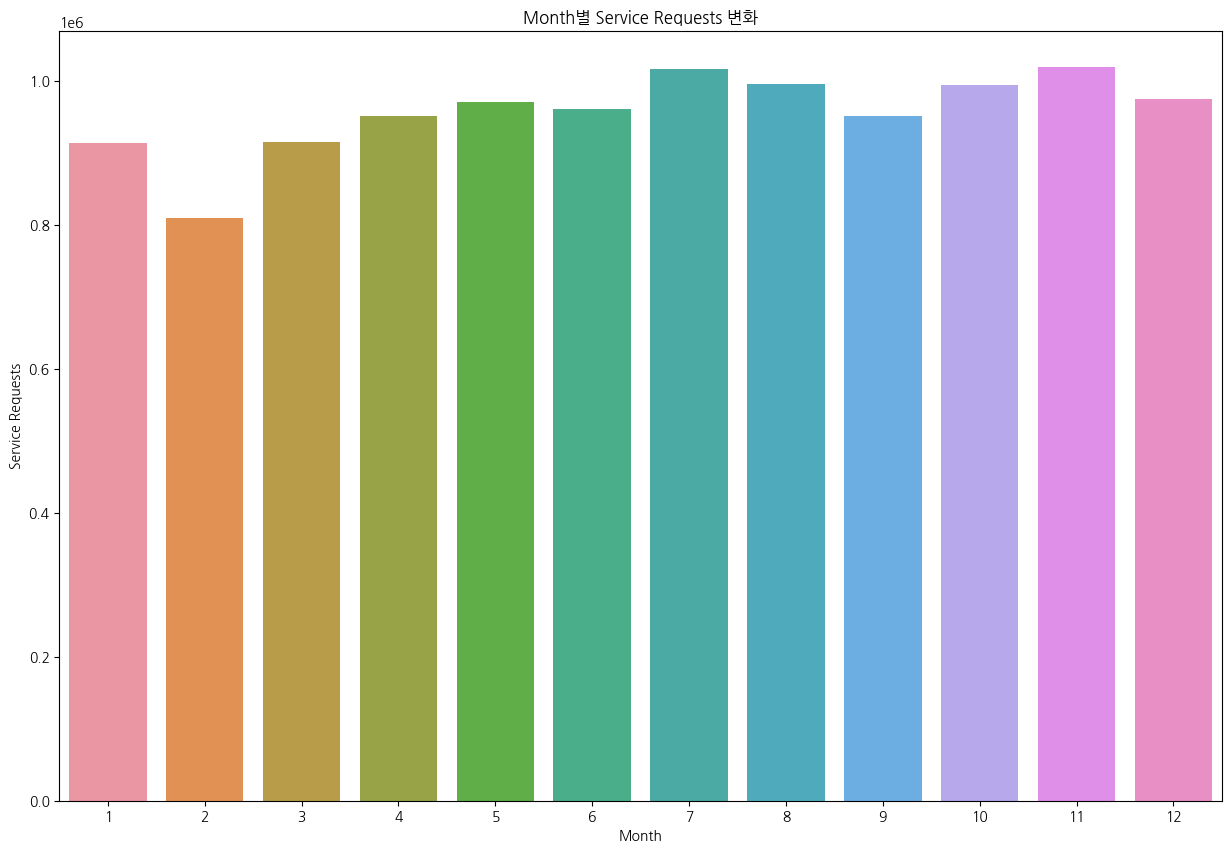

In [86]:
plot_barplot_analysis(taxi_copy, 'Month', 'Service Requests')


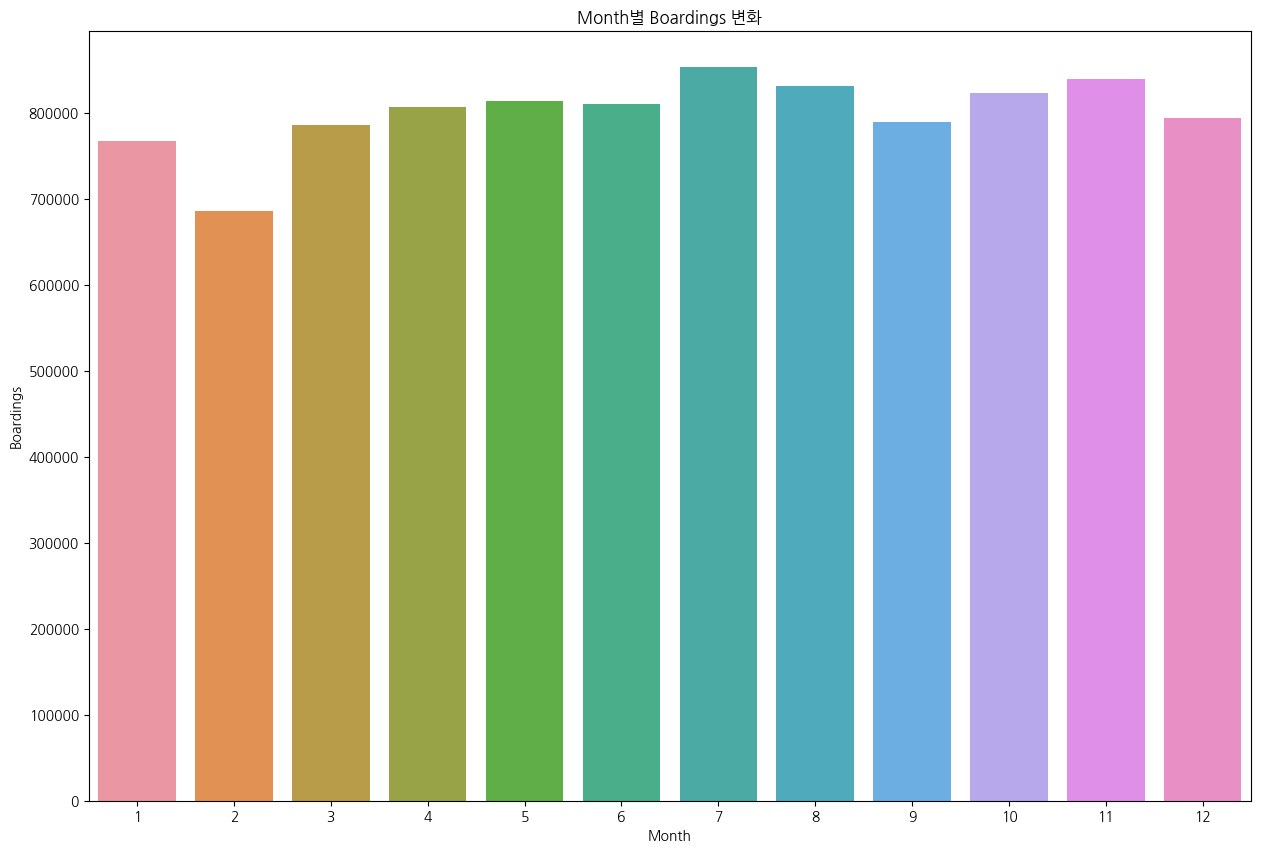

In [87]:
plot_barplot_analysis(taxi_copy, 'Month', 'Boardings')


* 대기시간

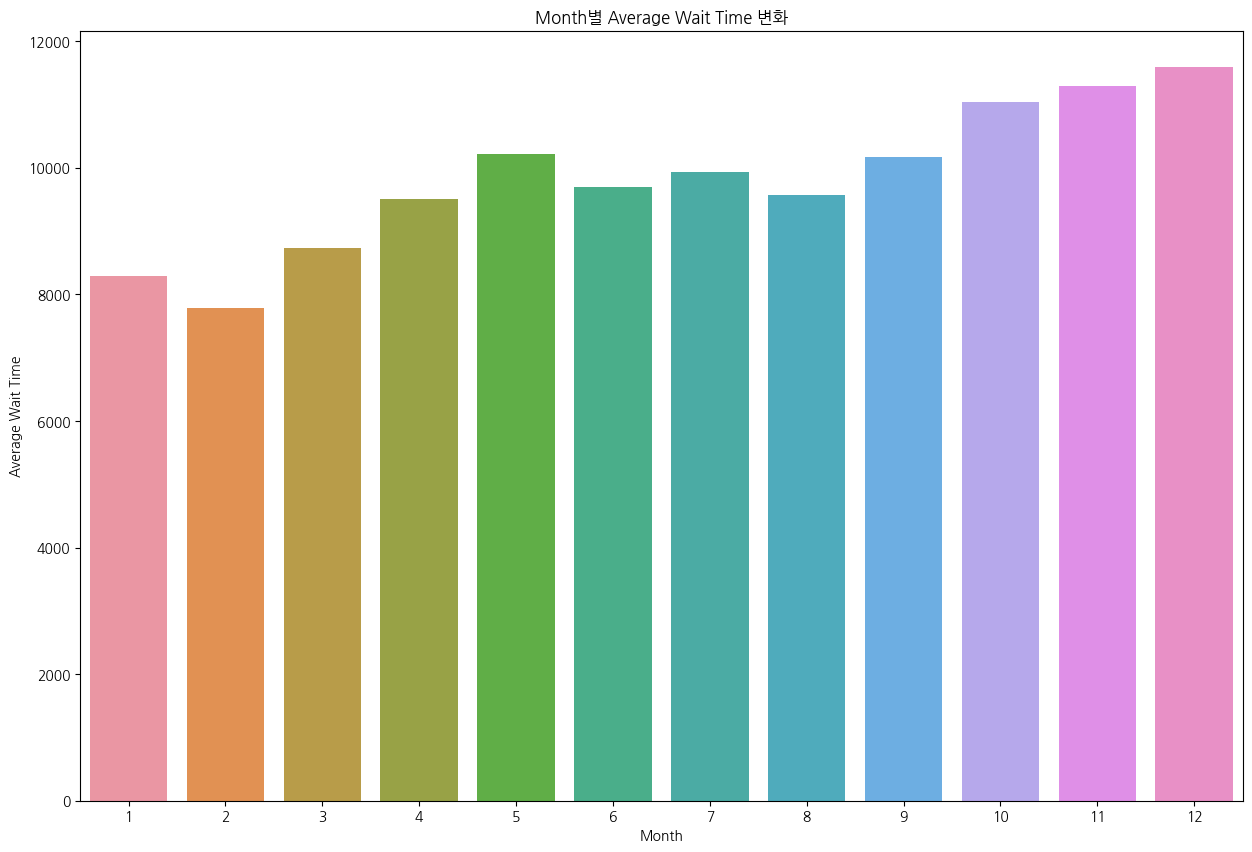

In [88]:
plot_barplot_analysis(taxi_copy, 'Month', 'Average Wait Time')


* 운임

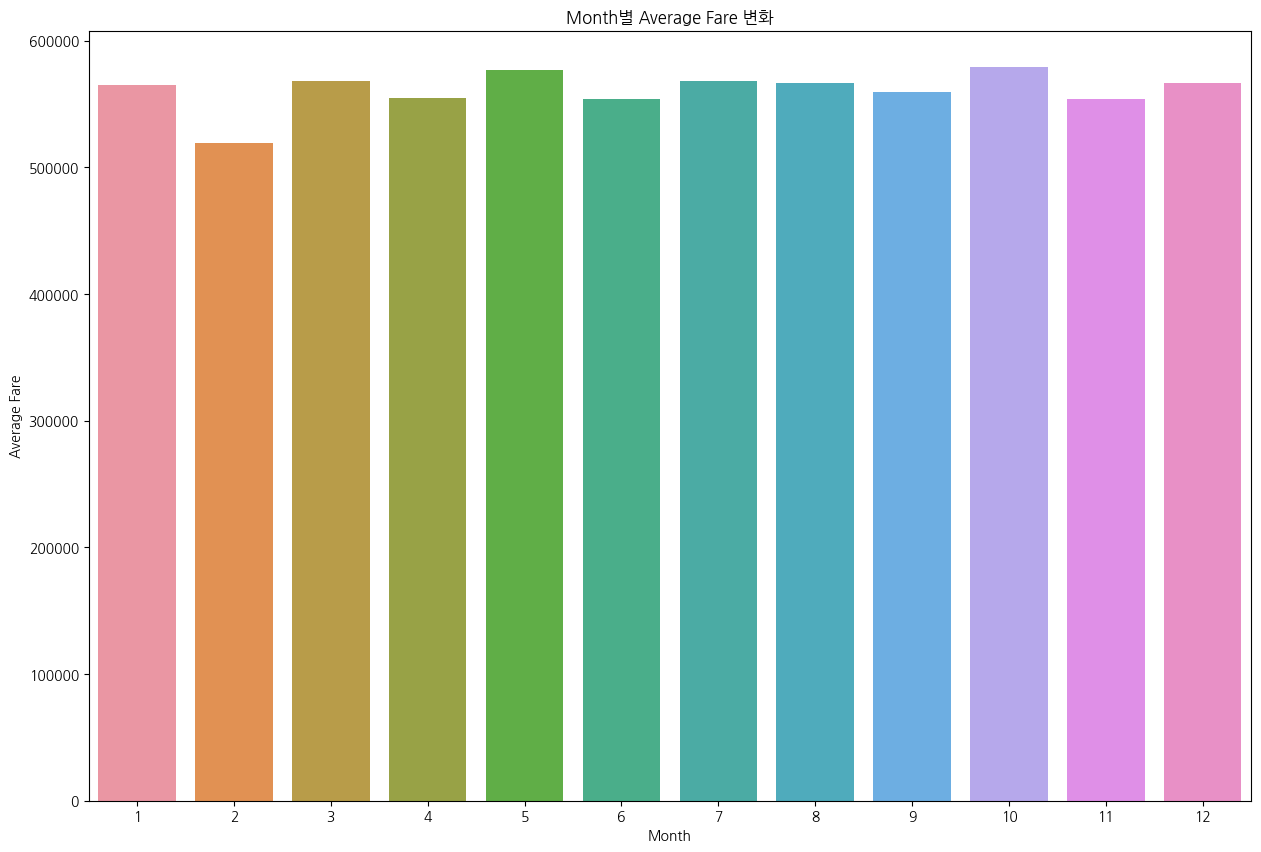

In [89]:
plot_barplot_analysis(taxi_copy, 'Month', 'Average Fare')


* 이동거리

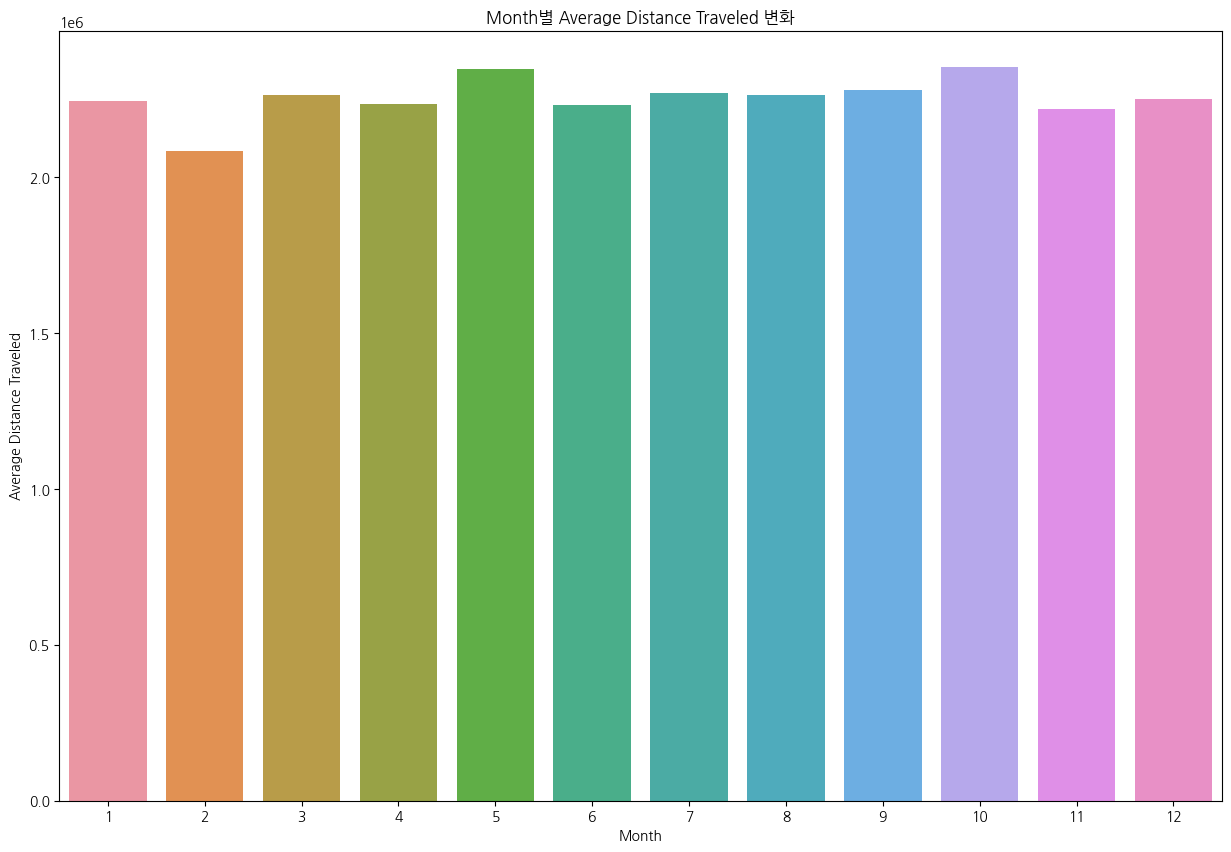

In [90]:
plot_barplot_analysis(taxi_copy, 'Month', 'Average Distance Traveled')


### (5) 연도별

* 차량 운행수

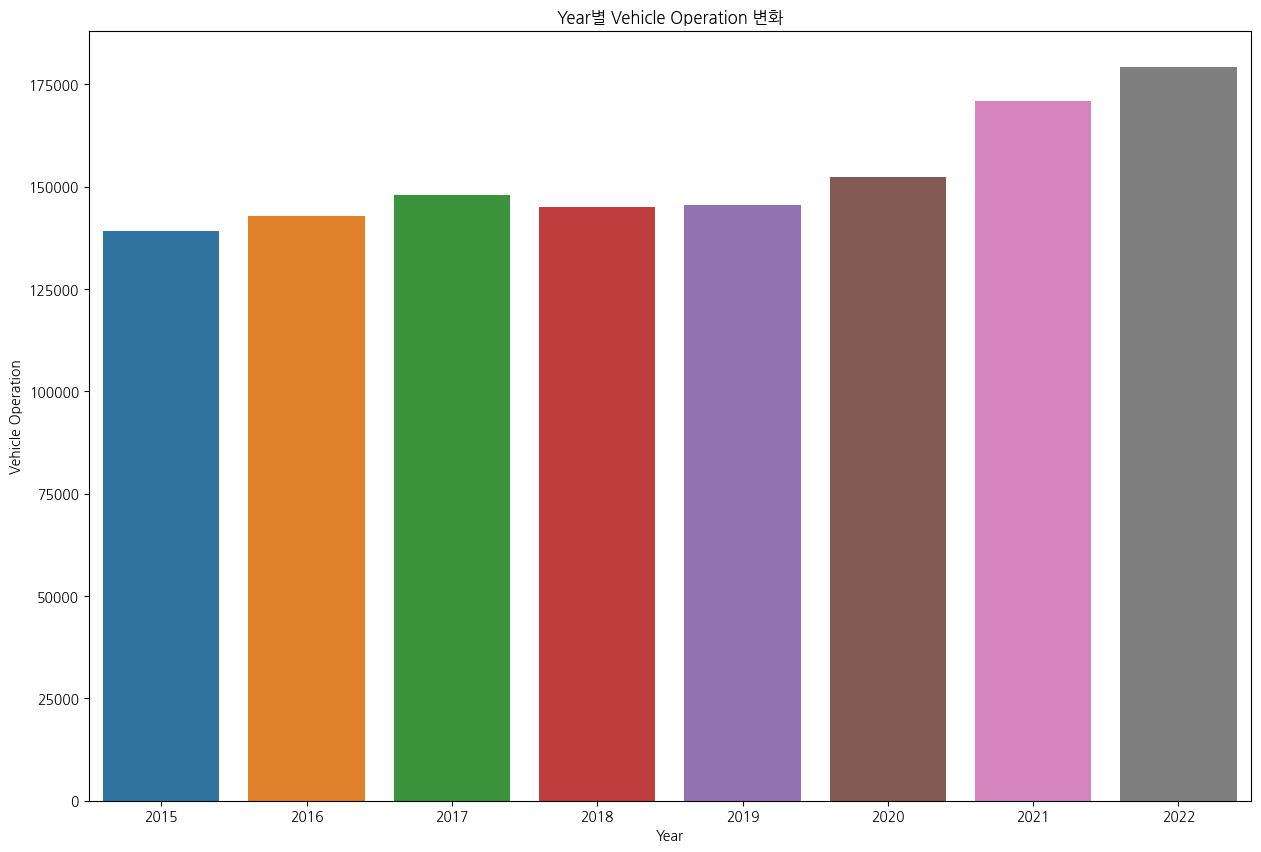

In [91]:
plot_barplot_analysis(taxi_copy, 'Year', 'Vehicle Operation')


* 대기시간

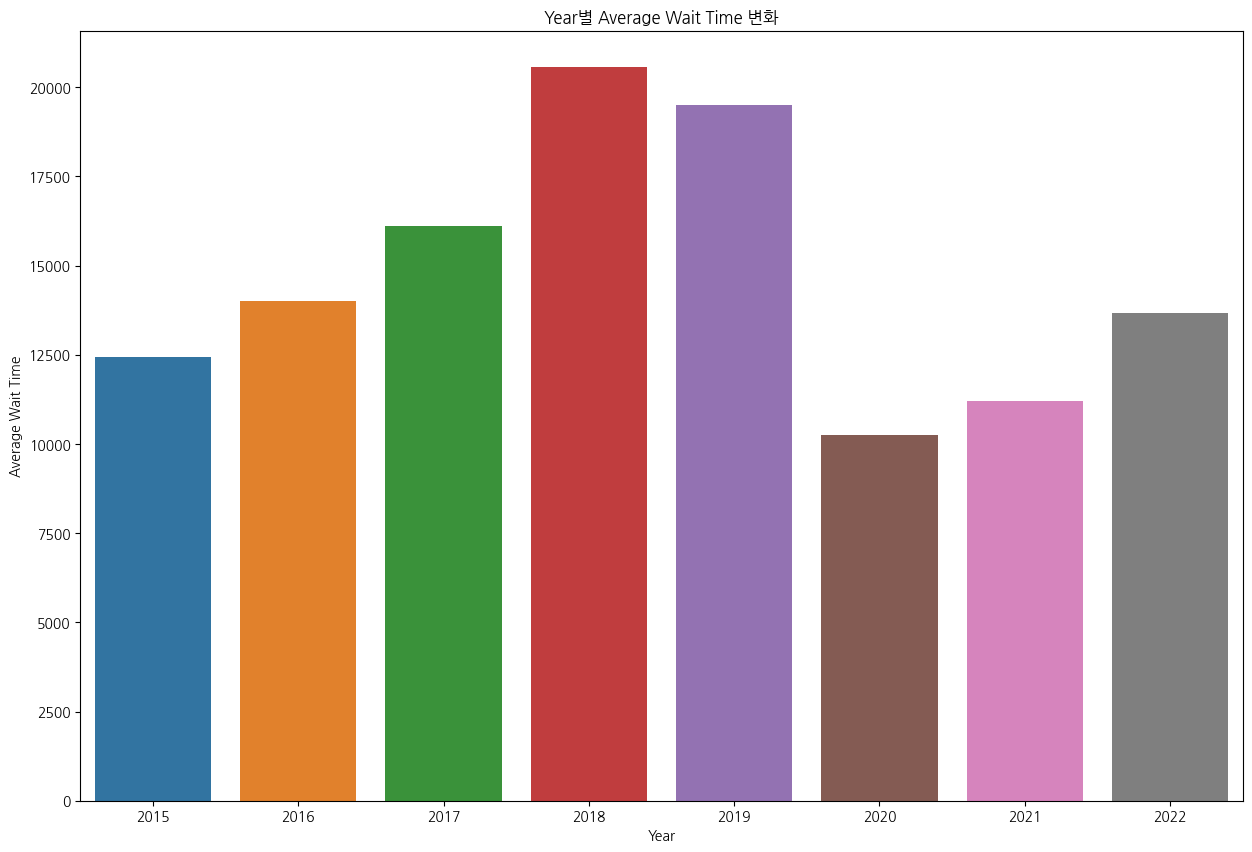

In [92]:
plot_barplot_analysis(taxi_copy, 'Year', 'Average Wait Time')


## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

In [ ]:
# 이미 shift된 데이터임 weather가 ㅇㅇ

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [105]:
# 예측 대상 날짜 생성 (현재 날짜 + 1일)
taxi_copy['prediction_date'] = taxi_copy['Date'] + pd.Timedelta(days=1)

# 예측하고자 하는 날짜 다음 날의 대기시간을 예측하므로, 예측 날짜 하루 전의 데이터를 사용합니다.
taxi_copy['target'] = taxi_copy['Average Wait Time'].shift(-1)

# target 변수가 float type 이므로, int type 으로 변환합니다.
# taxi_copy['target'] = taxi_copy['target'].astype(int)
# 마지막 날짜에 대한 target은 NaN으로 남게 됩니다. 해당 행 삭제
taxi_copy.dropna(subset=['target'], inplace=True)



In [106]:
taxi_copy.tail()

,Date,Vehicle Operation,Service Requests,Boardings,Average Wait Time,Average Fare,Average Distance Traveled,Day of Week,Week,Month,Year,prediction_date,target
2916,2022-12-26,603,5555,4605,39.2,2163,7889,Monday,52,12,2022,2022-12-27,44.4
2917,2022-12-27,669,5635,4654,44.4,2198,8178,Tuesday,52,12,2022,2022-12-28,44.8
2918,2022-12-28,607,5654,4648,44.8,2161,7882,Wednesday,52,12,2022,2022-12-29,52.5
2919,2022-12-29,581,5250,4247,52.5,2229,8433,Thursday,52,12,2022,2022-12-30,38.3
2920,2022-12-30,600,5293,4200,38.3,2183,8155,Friday,52,12,2022,2022-12-31,33.7


In [104]:
taxi_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2922 non-null   datetime64[ns]
 1   Vehicle Operation          2922 non-null   int64         
 2   Service Requests           2922 non-null   int64         
 3   Boardings                  2922 non-null   int64         
 4   Average Wait Time          2922 non-null   float64       
 5   Average Fare               2922 non-null   int64         
 6   Average Distance Traveled  2922 non-null   int64         
 7   Day of Week                2922 non-null   object        
 8   Week                       2922 non-null   int64         
 9   Month                      2922 non-null   int64         
 10  Year                       2922 non-null   int64         
 11  prediction_date            2922 non-null   datetime64[ns]
 12  target

### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [ ]:
!pip install workalendar

* 간단 사용법

In [ ]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

#### 4) 탑승률

## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl